## Panorama Stiching (Image Registration)
- Resources
    - [step by step tutorial](https://peerj.com/articles/453/) - also a very good summary of what skimage is and how it is compared with others in the community
    - [source code and data](https://github.com/scikit-image/skimage-demos)
- Technically
    - correlate the images by POI by features
    - build model by filtering/selecting matches
    - make corresponding transformation of each to make them aligned
    - stick them together

In [1]:
%matplotlib inline

In [58]:
import matplotlib.pyplot as plt
from skimage import io, feature, color, transform, measure
import numpy as np

[(1987, 3000, 3), (1987, 3000, 3), (1987, 3000, 3)]
[(497, 750), (497, 750), (497, 750)]


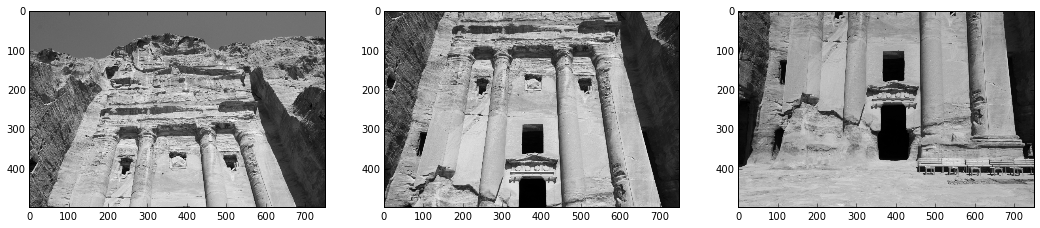

In [16]:
## load images, make them gray (as the features we used here don't care about colors)
## resize/rescale for better performance
imgs = io.ImageCollection("data/DFM_*.jpg")
print [img.shape for img in imgs]
imgs = [color.rgb2gray(transform.rescale(img, .25)) for img in imgs]
print [img.shape for img in imgs]

fig, axes = plt.subplots(1, 3, figsize = (18, 6))
axes = axes.ravel()
for img, ax in zip(imgs, axes):
    ax.imshow(img, cmap = plt.cm.gray)

(4000, 2) (4000, 256)
(1265, 2)


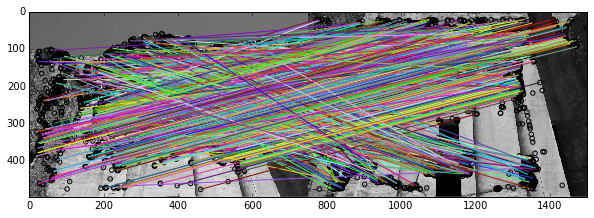

In [52]:
## extract features and find inital matches, e.g. by ORB - essentially corners
orber = feature.ORB(n_keypoints=4000)

## both keypoints and descriptors
kps, descs = [], []
for img in imgs:
    orber.detect_and_extract(img)
    kps.append(orber.keypoints)
    descs.append(orber.descriptors)
    
print kps[0].shape, descs[0].shape

## match based on descriptors - brute force and cross checked
match01 = feature.match_descriptors(*descs[:2], cross_check=True)
print match01.shape
## you should always inspect the match by plotting it
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
feature.plot_matches(ax, imgs[0], imgs[1], kps[0], kps[1], match01, )

(334, 2)


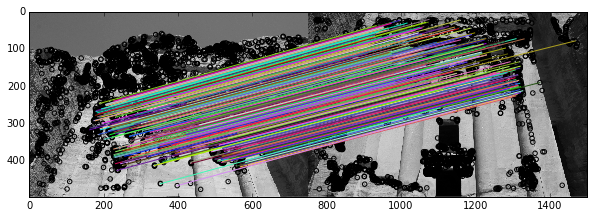

In [53]:
## obviously there is noise in the matching - because we expect ONLY the bottom part of 
## first image matches the top part of second image. 
## This is because we used more than enough keypoints (4K) in the above. 
## We need to further filter them out to find the true matches

## RANdom SAMple Consensus (RANSAC) for rejecting outliers
## HOW REJECTING OUTLIERS WORKS: we expect there is a pattern of the match in
## terms of the geometry of keypoints in the two images, i.e., top of img1 match bottom of img2
## and the pattern should be the majority (inliers) - that is why ransac is in measure module

## see why projectiveTransform is needed here
## https://www.quora.com/What-is-the-difference-between-affine-transformation-and-projective-transformation
## kps are point coordinates in rows and cols, each row of match01 contains indices of match, (img0, img1)
## latter we are gonna use the model learnt by ransac - a projectiveTransform, which assumes x,y coordinates though
## so we need to make it synchronized here
## common model_class choices are transform.ProjectiveTransform or measure.LinearModel (for fitting a line)
match_rcs = kps[0][match01[:, 0]][:,::-1], kps[1][match01[:,1]][:,::-1] ## translate r,c coord in keypoints into x,y
model, inliers = measure.ransac(data = match_rcs, model_class = transform.ProjectiveTransform, 
                                min_samples = 4, residual_threshold =1)

filtered_match01 = match01[inliers, :]
print filtered_match01.shape
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
feature.plot_matches(ax, imgs[0], imgs[1], kps[0], kps[1], filtered_match01, )

In [67]:
## warp the images by projectiveTransformation - so that they align
## first decide what the output image (for both warped img0 and img1) would be

## the registration target is img[1] - it will be warped
## define its corners and warped corners
nr, nc = imgs[1].shape
## in (x, y) format
corners = np.array([[0, 0]
                   ,[0, nr]
                   ,[nc, 0]
                   ,[nc, nr]])
warped_corners = model(corners)
all_corners = np.vstack( (corners, warped_corners) )
shape = all_corners.max(axis = 0) - all_corners.min(axis = 0)
output_shape = np.ceil(shape[::-1]).astype(int)

In [72]:
## warp imgs[0]
offset01 = transform.SimilarityTransform(translation=-all_corners.min(axis = 0))
transform01 = (model + offset01).inverse
## invalid pixels marked as -1
warped_img0 = transform.warp(imgs[0], transform01, order = 3, output_shape=output_shape, cval = -1)
warped_img0[warped_img0 == -1] = 0 # set invalid pixels as black ground

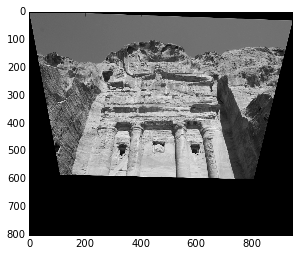

In [74]:
plt.imshow(warped_img0, cmap = plt.cm.gray)